# Images
An overview of the image data structure and manipulation.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/images.ipynb)

In [1]:
# Installation  
# for this demonstration we will use the data from the ALMA First Look at Imaging CASAguide
import os, warnings
warnings.simplefilter("ignore", category=RuntimeWarning)  # suppress warnings about nan-slices
print("installing casa6 and cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatasks==6.3.0.48")
os.system("pip install casadata")
os.system("pip install cngi-prototype==0.0.92")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz

print('complete')

installing casa6 and cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


## Initialize the Environment
`InitializeFramework` instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

```python
>>> from cngi.direct import InitializeFramework
>>> client = InitializeFramework(workers=4, memory='2GB')
>>> print(client)
<Client: 'tcp://127.0.0.1:33227' processes=4 threads=4, memory=8.00 GB>
```

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well, so we will let Dask use its default scheduler.


## Create Image Data
First we need to create a CASA image by calling CASA6 tclean on the CASAguide MS

Pro tip: you can see the files being created by expanding the left navigation bar in colab (little arrow on top left) and going to "Files"

In [2]:
from casatasks import tclean
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='',
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, pbcor=True,
       savemodel='modelcolumn', usemask='auto-multithresh')
print('complete')

complete


tclean produces an image along with a number of supporting products (residual, pb, psf, etc) in their own separate directories.  

CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format which is capable of storing all image products (of the same shape) together.

Note that the .mask image product will be renamed to 'automask' in the xarray data model and 'mask' will hold the mask pixel values extracted from the .image.

In [3]:
from cngi.conversion import convert_image

image_xds = convert_image('sis14_twhya_calibrated_flagged.image')

converting Image...
processed image in 1.7558475 seconds


Within the xarray dataset image, we can see a very clear definition of the image properties.  The **Dimensions** section holds the size of the image, while the **Coordinates** section defines the values of each dimension.  The actual image (and supporting products) are stored in the **Data variables** section.  Lastly, the **Attributes** section holds the remaining metadata.

Note that the variables *image*, *automask*, *mask*, *model*, *pb*, *psf*, and *residual* all share the same dimensions of 250x250x1x10 while the variable *sumwt* is a subset of dimensions 1x10

In [4]:
print(image_xds)

<xarray.Dataset>
Dimensions:            (chan: 10, l: 250, m: 250, pol: 1, time: 1)
Coordinates:
  * chan               (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11
    declination        (l, m) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
  * l                  (l) float64 6.06e-05 6.012e-05 ... -5.963e-05 -6.012e-05
  * m                  (m) float64 -6.06e-05 -6.012e-05 ... 5.963e-05 6.012e-05
  * pol                (pol) float64 1.0
    right_ascension    (l, m) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
  * time               (time) datetime64[ns] 2012-11-19T07:56:26.544000626
Data variables:
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (

The image has both cartesian pixel coordinates (l, m) and spherical world coordinates (right_ascension, declination).

The spherical nature of the multi-dimensional right_ascension and declination coordinate structures becomes clearer when we plot a very wide image:

converting Image...
processed image in 0.68170214 seconds


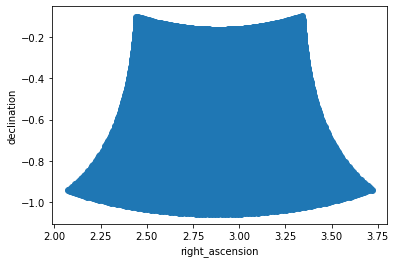

In [5]:
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='wide_cube', field='5', spw='', specmode='cube', cell='30arcmin',
       imsize=100, nchan=10, deconvolver='hogbom', niter=10, savemodel='modelcolumn', usemask='auto-multithresh')

widexds = convert_image('wide_cube.image')
widexds.plot.scatter(x='right_ascension', y='declination')

## Preview Image
We can quickly spot check image contents.  This is also handy later on during image manipulation and analysis.  Most image data is four-dimensional, so the plotting routine will collapse extra dimensions by taking the max (this is more robust than mean).

The image can be plotted using its spherical world coordinates or cartesian pixel indices

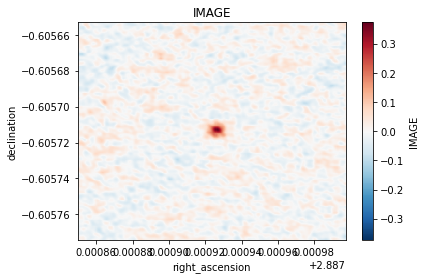

In [6]:
from cngi.image import implot

# just channel 5
implot(image_xds.IMAGE, axis=['right_ascension', 'declination'], chans=5)

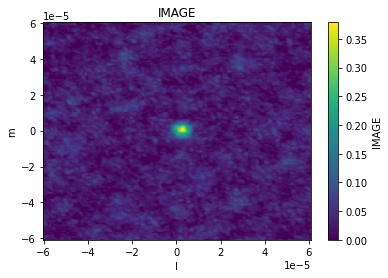

In [7]:
# max of all channels, with cartesian pixel indices
implot(image_xds.IMAGE, axis=['l', 'm'], chans=None)

Other image data products are plotted the same way

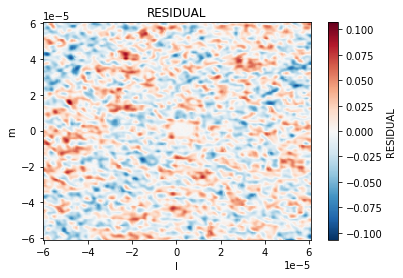

In [8]:
implot(image_xds.RESIDUAL, chans=5)

The plotting function has the same capabilities as the visibility routine, so we can also make scatter plots across coordinates and dimensions using the axis parameter. Other dimensions are collapsed by taking the max.

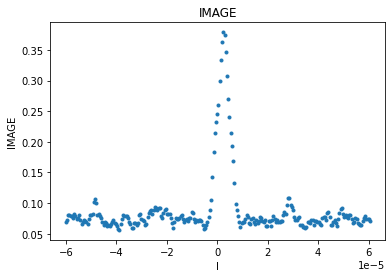

In [9]:
implot(image_xds.IMAGE, axis='l')

Looking across channels, it is clear that channel 0 is empty.  This is why the above plot across all channels is rescaled to a min value of 0.

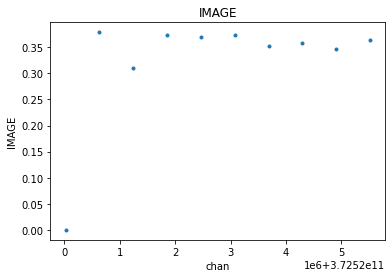

In [10]:
implot(image_xds.IMAGE, axis='chan')

## Basic Manipulation
Many image operations can be easily done directly on the image xarray dataset

**Example 1: imsubimage** - copy all or part of an image to a new image

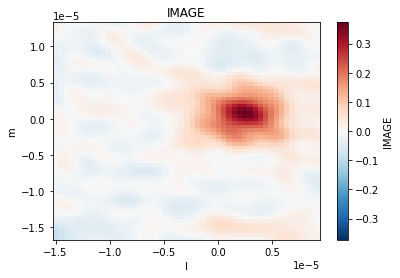

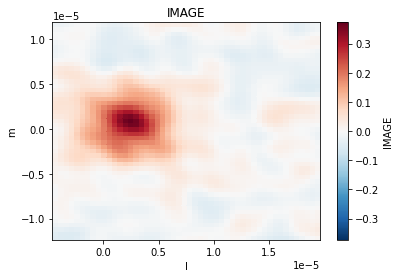

In [11]:
# selection by coordinate values
image_xds2 = image_xds.where( (image_xds.right_ascension > 2.887905) & (image_xds.right_ascension < 2.887935) &
                              (image_xds.declination > -0.60573) & (image_xds.declination < -0.60570), drop=True ) 
implot(image_xds2.IMAGE, chans=5)

# selection by pixel indices (50x50 pixel square)
# note that this same method works for any other dimension (stokes, channels, etc)
image_xds2 = image_xds.isel(l=range(85,135), m=range(100,150))
implot(image_xds2.IMAGE, chans=5)

**Example 2: imtrans** - reorders (transposes) the axes in the input image to the specified order

This can be done on the entire dataset, or just one variable in the dataset. Here we will do it on the whole thing which is probably best if you want to preserve your regions and masks (explained later).  This will generally not affect the preview plot since it selects axes by name rather than index. That is one advantage of xarray over numpy.

In [12]:
image_xds2 = image_xds.transpose('chan','m','time','l','pol')
print('Before\n', image_xds.data_vars)
print('\nAfter\n', image_xds2.data_vars)

Before
 Data variables:
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, chan, pol) float64 dask.array<chunksi

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Again, this can be done on the entire dataset, or just one variable in the dataset. Refer to the [xarray documentation](http://xarray.pydata.org/en/stable/api.html#dataset) for supported aggregation functions, or write your own and call *reduce*.  This will generally break the preview plot since it is expecting a 4-D cube with ra, dec, stokes, and frequency axes

In [13]:
# one dimension collapse
image_xds2 = image_xds.sum(dim='chan')
print('One dimension collapse\n', image_xds2.data_vars)

# multi-dimension collapse
image_xds2 = image_xds.mean(dim=['l','m'])
print('\nMulti-dimension collapse\n', image_xds2.data_vars)


One dimension collapse
 Data variables:
    AUTOMASK           (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    RESIDUAL         

## Regions and Masks
Both regions and masks are stored as boolean arrays in the same xarray dataset alongside the rest of the image components.  They always share the same dimensions as the image.

They are both now treated as the same thing, so a value of 0 means "discard this pixel" and a value of 1 means "keep this pixel" regardless of whether it is a mask or a region.  In fact, any xarray data variable of boolean type can be used as a region/mask, there is nothing special about the names.

Regions/masks can be set across any dimension, so they can be per-channel and per-stokes as well as the spatial dimensions.


**Regions**

First lets create a couple examples:

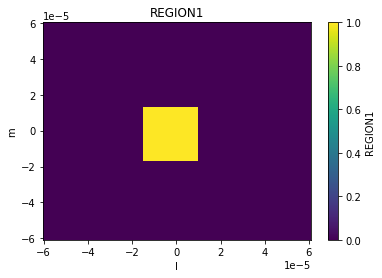

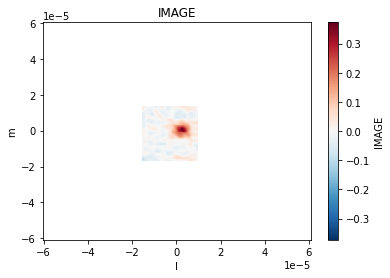

In [14]:
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'REGION1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

# lets examine what it looks like
implot(image_xds2.REGION1, chans=5)

# and combined with our image
implot(image_xds2.IMAGE.where(image_xds2.REGION1), chans=5)

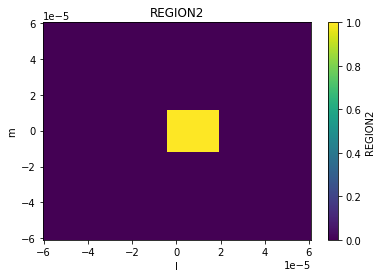

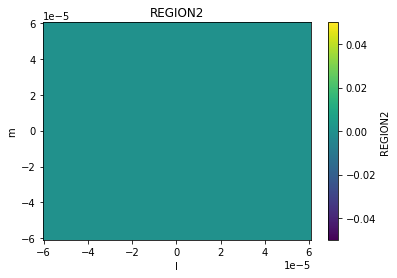

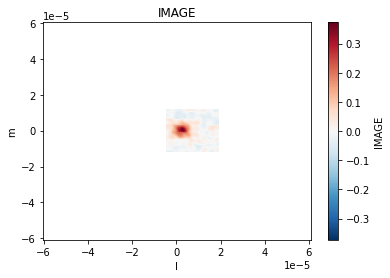

In [15]:
# region 2 is a pixel box across channels 3, 4 and 5
image_xds3 = region(image_xds2, 'REGION2', pixels=[[85,100],[135,150]], channels=[3,4,5])

# observe the change in behavior across channels
implot(image_xds3.REGION2, chans=5)
implot(image_xds3.REGION2, chans=6)
implot(image_xds3.IMAGE.where(image_xds3.REGION2), chans=[5,6])

Regions are just data variables in the xarray dataset. So we can manipulate them the same way we can any other variable.

In [16]:
image_xds3.data_vars

Data variables: (12/14)
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    ...                 ...
    PSF                (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    RESIDUAL           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    RESIDUAL_MASK0     (l, m, time, chan, 

Let's combine the first two regions in to a new one (doesn't need to be contiguous, although it is here). It is just a logical OR of two boolean arrays (obviously you could do an AND, XOR, or whatever else).

Just keep in mind that these are 4-D arrays, not 2-D.

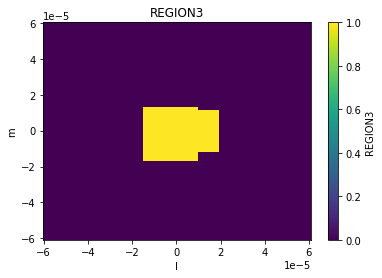

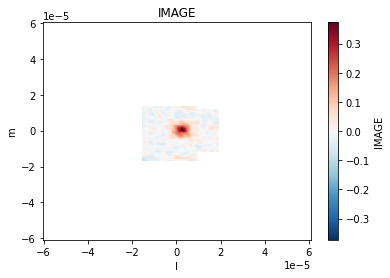

In [17]:
region3 = image_xds3.REGION1 | image_xds3.REGION2
image_xds4 = image_xds3.assign(dict([('REGION3', region3)]))
 
implot(image_xds4.REGION3, chans=5)
implot(image_xds4.IMAGE.where(image_xds4.REGION3), chans=5)

**Masks**

Masks are just like regions but with inverse logic used to set them.  Here is the same code again using calls to mask instead of region.

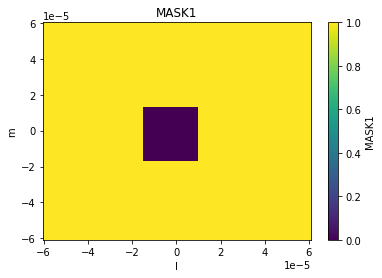

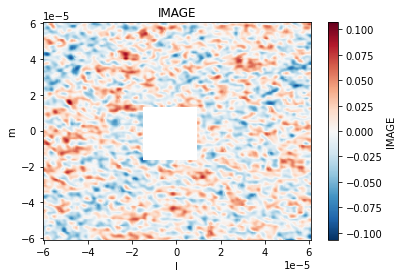

In [18]:
from cngi.image import mask

image_xds2 = mask(image_xds, 'MASK1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

implot(image_xds2.MASK1, chans=5)
implot(image_xds2.IMAGE.where(image_xds2.MASK1), chans=5)

Our converted image actually had two masks in it already, the variables *mask* and *deconvolve*.  Deconvolve is named differently because it is the mask set by auto-masking for the deconvolution rather than an image mask.  

These actually look a lot more like regions than masks, but that's the terminology that was used.  Again, they are the same thing anyway

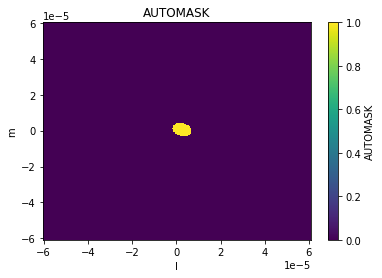

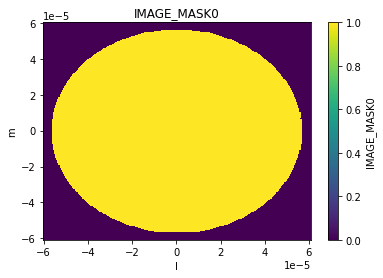

In [19]:
implot(image_xds2.AUTOMASK, chans=5)
implot(image_xds2.IMAGE_MASK0, chans=5)

**Manipulation with Regions and Masks**

All of the previously discussed image manipulation techniques can be done with regions and masks applied.  Just subselect the pixels within the region (outside the mask) first.  This is done with *dataset.where(..., drop=True)* 

Here is example 3 again with a region applied.

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Mean pixel values by channel :  [[0.         0.00093286 0.00062536 0.00089549 0.00076526 0.00075191
  0.00072434 0.00098554 0.00082396 0.00076053]] 



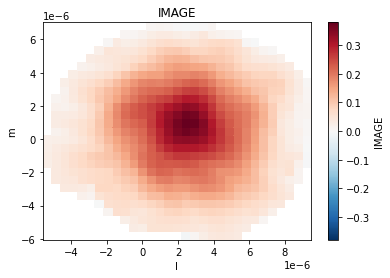


With deconvolve mask applied :  [[0.10387148 0.09331284 0.11133925 0.18792972 0.18861415 0.11964889
  0.11996713 0.0927346  0.10202092]]


In [20]:
# full image collapse
image_xds2 = image_xds.mean(dim=['l','m'])
print('Mean pixel values by channel : ', image_xds2.isel(pol=0).IMAGE.values, '\n')

# apply deconvolve region from auto-masking
image_xds2 = image_xds.where(image_xds.AUTOMASK, drop=True)
implot(image_xds2.IMAGE)

# collapse just the region
image_xds2 = image_xds2.mean(dim=['l','m'])
print('\nWith deconvolve mask applied : ', image_xds2.isel(pol=0).IMAGE.values)

## Beams and Smoothing
Smoothing an image involves creating and convolving beams of appropriate parameters to achieve the desired target properties in the image.

**Creating Beams**

Beams may be created as additional products in the image xarray Dataset. They may also be present already in parameterized form inside the attributes section.

First lets expand the parameterized per-plane beams defined in the xds attributes section.  This beam is defined across the channels and polarization axes.

restoring beam parameters (chan 5) :  [[0.6526952385902405, 0.5043563842773438, -65.88957977294922]]


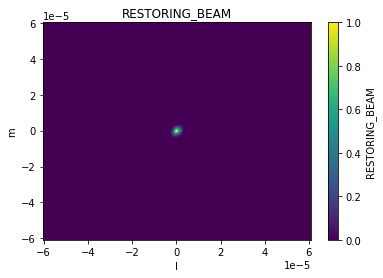

restoring beam dimensions:  (250, 250, 10, 1)


In [21]:
from cngi.image import gaussian_beam

print('restoring beam parameters (chan 5) : ', image_xds.perplanebeams[5])

image_xds2 = gaussian_beam(image_xds, source='perplanebeams', name='RESTORING_BEAM')

implot(image_xds2.RESTORING_BEAM)
print('restoring beam dimensions: ', image_xds2.RESTORING_BEAM.shape)

Now lets create a larger beam from our own parameters.  This one has only spatial dimensions.

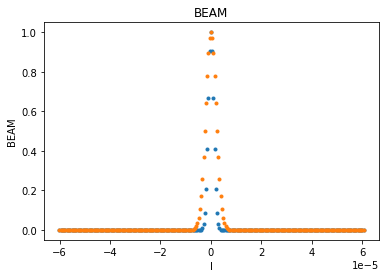

custom beam dimensions:  (250, 250)


In [22]:
image_xds2 = gaussian_beam(image_xds2, source=[1., 1., 30], name='BEAM')

implot(image_xds2.RESTORING_BEAM, 'l', drawplot=False)
implot(image_xds2.BEAM, 'l', overplot=True)
print('custom beam dimensions: ', image_xds2.BEAM.shape)

**Smoothing with Beams**

The smooth function can take an existing beam and convolve it across the image to produce a new output image. 

original image


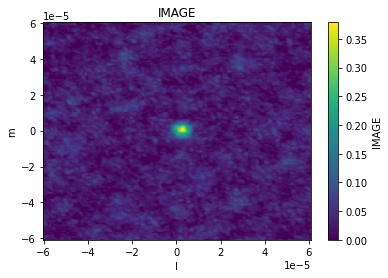

smooth image


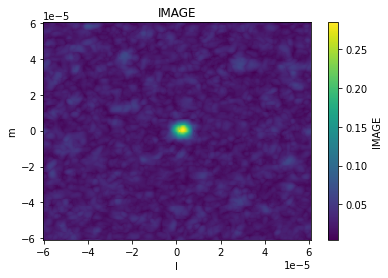

In [23]:
from cngi.image import smooth

# smooth with the restoring beam
image_xds3 = smooth(image_xds2, kernel='RESTORING_BEAM')

print('original image')
implot(image_xds2.IMAGE)

print('smooth image')
implot(image_xds3.IMAGE)

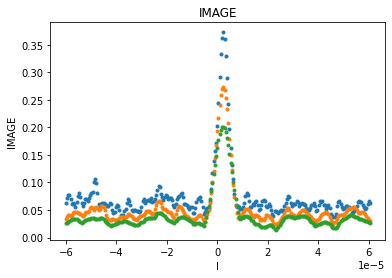

In [24]:
# smooth with our larger custom beam
image_xds4 = smooth(image_xds2, kernel='BEAM')

implot(image_xds.IMAGE, axis='l', chans=5, drawplot=False)
implot(image_xds3.IMAGE, axis='l', chans=5, overplot=True, drawplot=False)
implot(image_xds4.IMAGE, axis='l', chans=5, overplot=True)

If the image has already been smoothed by a previous beam, the smooth function can take the parameters of a new desired beam and construct the appropriate correcting beam to produce that target. The correcting beam used for smoothing is saved in the output xarray Dataset.

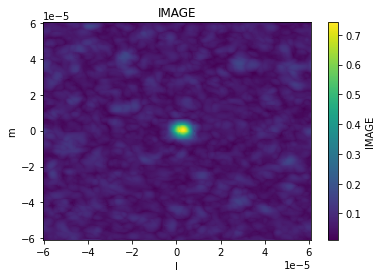

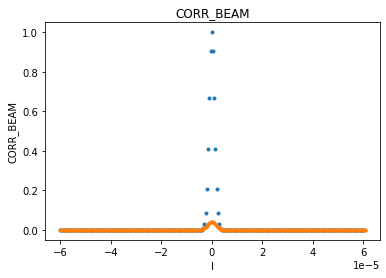

In [25]:
image_xds3 = smooth(image_xds2, kernel='gaussian', size=(1., 1., 60.), current=(0.65305, 0.50467, -66.), name='CORR_BEAM')

implot(image_xds3.IMAGE)
implot(image_xds3.RESTORING_BEAM, axis='l', chans=5, drawplot=False)
implot(image_xds3.CORR_BEAM, axis='l', overplot=True)

## Moments

The ```moments``` function is used to compute moments on the specified image xds data_var.  Moments are stored as additional data_vars in the returned xds. 


In [26]:
from cngi.image import moments, implot

image_xds2 = moments(image_xds, moment=[-1,0,1,2,3,4,5,6,7,8,9,10,11], axis='chan')

print(image_xds2.data_vars)

Data variables: (12/25)
    AUTOMASK                           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE                              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0                        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR                        (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0                  (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    MODEL                              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    ...                                 ...
    MOMENTS_RMS                        (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    MOMENTS_ABS_MEAN_DEV             

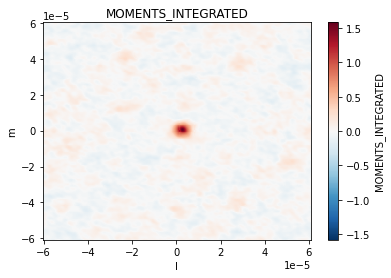

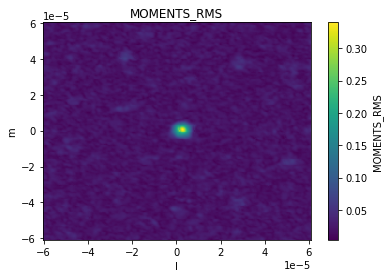

In [27]:
implot(image_xds2.MOMENTS_INTEGRATED)
implot(image_xds2.MOMENTS_RMS)

Use basic manipulation, regions, or masks before hand to select a subset of the image for moments

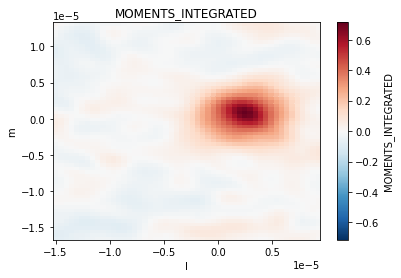

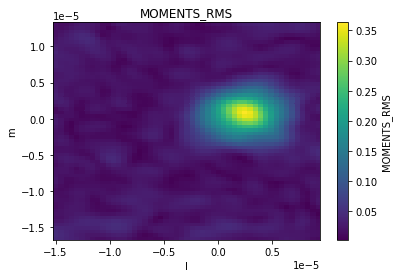

In [28]:
# Example for creating selected moment maps for selected channels
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'REGION1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570]).isel(chan=[4,5,6,7])
image_xds2 = moments(image_xds2.where(image_xds2.REGION1, drop=True), moment = [0,6])

implot(image_xds2.MOMENTS_INTEGRATED)
implot(image_xds2.MOMENTS_RMS)

## Statistics

The ```statistics``` function is used to compute statistics on the specific image xds data_var. The results are placed in the attributes section of the returned xds.

By default this is done in a lazy fashion so as not to break the xds DAG.  To see the actual value of a statistic, the ```.values``` method is needed.



In [29]:
from cngi.image import statistics

image_xds2 = statistics(image_xds, dv='IMAGE', name='statistics')

print('computed statistics:\n -', '\n - '.join(list(image_xds2.statistics.keys())))

print('\nlazy statistic (mean) :', image_xds2.statistics['mean'])
print('\ncomputed statistic (mean) :', image_xds2.statistics['mean'].values.item())

computed statistics:
 - max
 - maxpos
 - maxposf
 - mean
 - medabsdevmed
 - median
 - min
 - minpos
 - minposf
 - npts
 - q1
 - q3
 - quartile
 - rms
 - sigma
 - sum
 - sumsq
 - blc
 - blcf
 - trc
 - trcf

lazy statistic (mean) : <xarray.DataArray 'IMAGE' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

computed statistic (mean) : 0.0007265257783630225


Optionally, ```compute=True``` can be passed to the ```statistics``` function.  This will break the DAG and could be costly in terms of performance.

In [30]:
image_xds2 = statistics(image_xds, dv='IMAGE', name='statistics', compute=True)

for kk in image_xds2.statistics.keys():
   print(kk + ': ', image_xds2.statistics[kk])

max:  0.3788154721260071
maxpos:  [120, 127, 0, 1, 0]
maxposf:  ['11:01:51.83654673', '-34.42.17.16599958', '2012-11-19T07:56:26.544000626', 372520632933.7965, 1.0]
mean:  0.0007265257783630225
medabsdevmed:  0.013578892219811678
median:  0.0
min:  -0.11158199608325958
minpos:  [208, 245, 0, 2, 0]
minposf:  ['11:01:51.12295091', '-34.42.05.36588434', '2012-11-19T07:56:26.544000626', 372521243263.95557, 1.0]
npts:  625000
q1:  -0.013601248385384679
q3:  0.013555713929235935
quartile:  0.027156962314620614
rms:  0.024755708055986946
sigma:  0.024745044789747924
sum:  454.078611476889
sumsq:  383.02817584578554
blc:  [0 0 0 0 0]
blcf:  ['11:01:52.80971154', '-34.42.29.86573768', '2012-11-19T07:56:26.544000626', 372520022603.63745, 1.0]
trc:  [249 249   0   9   0]
trcf:  ['11:01:50.79048222', '-34.42.04.96574187', '2012-11-19T07:56:26.544000626', 372525515575.069, 1.0]


Use basic manipulation, regions, or masks before hand to select a subset of the image for statistics

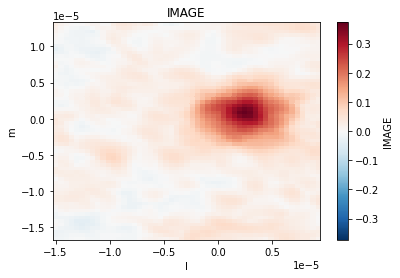

max:  0.3726564943790436
maxpos:  [14, 36, 0, 1, 0]
maxposf:  ['11:01:51.83654673', '-34.42.17.16599958', '2012-11-19T07:56:26.544000626', 372523074254.43274, 1.0]
mean:  0.016538425474854918
medabsdevmed:  0.019604451023042202
median:  0.0023901931708678603
min:  -0.0871538370847702
minpos:  [50, 1, 0, 1, 0]
minposf:  ['11:01:51.5446073', '-34.42.20.66598387', '2012-11-19T07:56:26.544000626', 372523074254.43274, 1.0]
npts:  12648
q1:  -0.01503333286382258
q3:  0.025363899767398834
quartile:  0.040397232631221414
rms:  0.060676759432310934
sigma:  0.05837935952046069
sum:  209.178005405965
sumsq:  46.565751222092246
blc:  [0 0 0 0 0]
blcf:  ['11:01:51.95007945', '-34.42.20.76599394', '2012-11-19T07:56:26.544000626', 372522463924.2737, 1.0]
trc:  [50 61  0  3  0]
trcf:  ['11:01:51.54461237', '-34.42.14.66598387', '2012-11-19T07:56:26.544000626', 372524294914.75085, 1.0]


In [31]:
# Example of select region and print the statistics.
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'REGION1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570]).isel(chan=[4,5,6,7])
image_xds2 = statistics(image_xds2.where(image_xds2.REGION1, drop=True), dv='IMAGE', name='statistics', compute=True)

implot(image_xds2.IMAGE)

for kk in image_xds2.statistics.keys():
   print(kk + ': ', image_xds2.statistics[kk])

## Spectral Line Fitting
Adapted from https://github.com/emilyripka/BlogRepo/blob/master/181119_PeakFitting.ipynb
Dave Mehringer 2021mar01

In [32]:
# Create a blank image in CASA 6
import casatools
import numpy as np

myia = casatools.image()
nchan = 100
myia.fromshape("gaussfit.im",[20,20,nchan,1], overwrite=True)

# insert the model spectrum
x_vals = np.linspace(0,nchan-1,nchan)
y_vals = 20*(np.exp((-1.0/2.0)*(((x_vals-(nchan/2))/10)**2)))
pix = myia.getchunk()
pix[10, 10, :, 0] = y_vals
myia.putchunk(pix)

# add some noise
myia.addnoise()
myia.done()

# convert to CNGI image
image_xds10 = convert_image('gaussfit.im')

converting Image...
processed image in 0.32384706 seconds


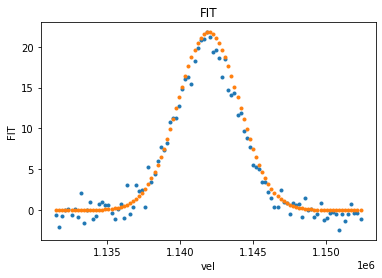

In [33]:
# convert freqs to velocities
from cngi.image import spec_fit, implot

nxds = spec_fit(image_xds10, dv='IM', pixel=(10,10), name='FIT')

implot(nxds.IM[10,10,0,:,0], axis='vel', drawplot=False)
implot(nxds.FIT, axis='vel', overplot=True)

## Continuum Subtraction
The image cont_sub function estimates and subtracts continuum emission from an image cube. The line emission and continuum images are stored as additional data_vars in the returned xds




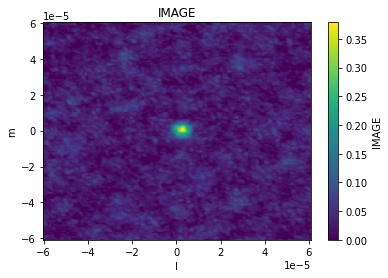

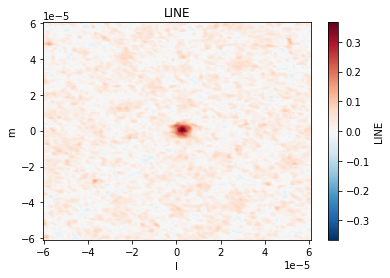

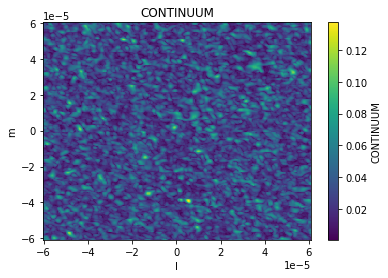

In [34]:
from cngi.image import cont_sub

# Fit a second order polynomial (fitorder=2) to channels 1-3 and 7-9 to an RA x Dec x Frequency x Stokes cube. 
image_xds2 = cont_sub(image_xds, dv='IMAGE', fitorder=2, chans=[1,2,3,7,8,9], linename='LINE', contname='CONTINUUM')

implot(image_xds2.IMAGE)
implot(image_xds2.LINE)
implot(image_xds2.CONTINUUM)

The accuracy of the polynomial fit is stored in the attributes section of the returned xds.  By default this is not computed (left as lazy DAG).  Use the ```values``` method to see the results.  Alternatively, ```compute=True``` may be passed to the ```spec_fit``` function.

In [35]:
print(image_xds2.line)

{'rms_error': <xarray.DataArray ()>
dask.array<pow, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>, 'min_max_error': [<xarray.DataArray ()>
dask.array<nanmin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>, <xarray.DataArray ()>
dask.array<nanmax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>], 'bw_frac': 0.6, 'freq_frac': <xarray.DataArray 'chan' ()>
array(0.88888889)}


In [36]:
image_xds2 = cont_sub(image_xds, dv='IMAGE', fitorder=2, chans=[1,2,3,7,8,9], linename='LINE', contname='CONTINUUM', compute=True)

print(image_xds2.line)

{'rms_error': 0.0132873388624595, 'min_max_error': [9.583802056817303e-08, 0.06687562817485812], 'bw_frac': 0.6, 'freq_frac': 0.8888888888888888}
